In [1]:
from sklearn.model_selection import train_test_split
import shap
import numpy as np
import pandas as pd

import pickle 

from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Prepared Data and Models

In [5]:
with open('data/df_X.pkl', 'rb') as f:
    df_X = pickle.load(f)
with open('data/df_y.pkl', 'rb') as f:
    df_y = pickle.load(f)
with open('data/df_X_display.pkl', 'rb') as f:
    df_X_display = pickle.load(f)
with open('data/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('data/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('data/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('data/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
with open('models/shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)
with open('models/shap_explainer.pkl', 'rb') as f:
    explainer = pickle.load(f)
with open('models/adult_model.pkl', 'rb') as f:
    adult_model = pickle.load(f)

In [6]:
male_indices = df_X[df_X['gender'] == 1].index.values
female_indices = df_X[df_X['gender'] == 0].index.values
white_indices = df_X[df_X['race'] == 1].index.values
black_indices = df_X[df_X['race'] == 0].index.values

In [7]:
male_indices_test = X_test[X_test['gender'] == 1].index.values
female_indices_test = X_test[X_test['gender'] == 0].index.values
white_indices_test = X_test[X_test['race'] == 1].index.values
black_indices_test = X_test[X_test['race'] == 0].index.values

In [8]:
y = df_y.values.reshape(len(df_y),)
y_male = y[male_indices]
y_female = y[female_indices]
y_white = y[white_indices]
y_black = y[black_indices]

y_male_test = y[male_indices_test]
y_female_test = y[female_indices_test]
y_white_test = y[white_indices_test]
y_black_test = y[black_indices_test]

In [9]:
y_pred = adult_model.predict(df_X)
y_pred_male = y_pred[male_indices]
y_pred_female = y_pred[female_indices]
y_pred_white = y_pred[white_indices]
y_pred_black = y_pred[black_indices]

y_pred_male_test = y_pred[male_indices_test]
y_pred_female_test = y_pred[female_indices_test]
y_pred_white_test = y_pred[white_indices_test]
y_pred_black_test = y_pred[black_indices_test]

In [60]:
y_pred_proba = adult_model.predict_proba(df_X)
y_pred_proba_male_test = y_pred_proba[male_indices_test, :]
y_pred_proba_female_test = y_pred_proba[female_indices_test, :]
y_pred_proba_white_test = y_pred_proba[white_indices_test, :]
y_pred_proba_black_test = y_pred_proba[black_indices_test, :]

In [10]:
def compute_pos_rate(y):
    return y.sum() / len(y)

In [11]:
pos_rate = compute_pos_rate(y)
pred_pos_rate = compute_pos_rate(y_pred)

pos_rate_male = compute_pos_rate(y_male)
pos_rate_female = compute_pos_rate(y_female)
pred_pos_rate_male = compute_pos_rate(y_pred_male)
pred_pos_rate_female = compute_pos_rate(y_pred_female)

pos_rate_white = compute_pos_rate(y_white)
pos_rate_black = compute_pos_rate(y_black)
pred_pos_rate_white = compute_pos_rate(y_pred_white)
pred_pos_rate_black = compute_pos_rate(y_pred_black)

In [12]:
test_pos_rate = compute_pos_rate(y_test)
pred_test_pos_rate = compute_pos_rate(y_pred_test)

test_pos_rate_male = compute_pos_rate(y_male_test)
test_pos_rate_female = compute_pos_rate(y_female_test)
pred_test_pos_rate_male = compute_pos_rate(y_pred_male_test)
pred_test_pos_rate_female = compute_pos_rate(y_pred_female_test)

test_pos_rate_white = compute_pos_rate(y_white_test)
test_pos_rate_black = compute_pos_rate(y_black_test)
pred_test_pos_rate_white = compute_pos_rate(y_pred_white_test)
pred_test_pos_rate_black = compute_pos_rate(y_pred_black_test)

# Demographic Parity

It asserts that average of algorithmic decisions should be similar across different groups: p(ˆy=1|z=0) / p(ˆy=1|z=1) ≥ τ , where τ is a given threshold, usually set as 0.8

Note z = 0 => minority group, z = 1 => majority group.

In [13]:
dem_par_gender = pred_test_pos_rate_female / pred_test_pos_rate_male

In [14]:
dem_par_race = pred_test_pos_rate_black / pred_test_pos_rate_white

In [15]:
def plot_bar(values, labels, ax, color='b'):
    bar_width = 0.35
    opacity = 0.9
    index = np.arange(len(values))
    
    ax.bar(index, values, bar_width,
           alpha=opacity,
           color=color)
    ax.set_xticks(index)
    ax.set_xticklabels(labels)
    ax.grid(True);

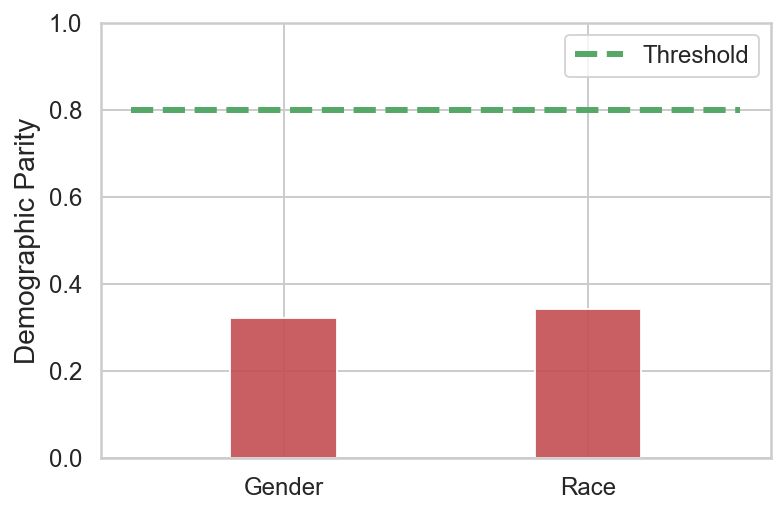

In [16]:
threshold = 0.8
f, ax = plt.subplots()
plot_bar([dem_par_gender, dem_par_race], ['Gender', 'Race'], 
         ax=ax, color='r')
ax.set_ylabel('Demographic Parity')
ax.set_ylim([0, 1])
ax.plot([-0.5, 1.5], [threshold, threshold], "g--", 
        label='Threshold',
        linewidth=3.0)
ax.legend();
f.savefig('images/chapter_08_demographic_parity.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_08_demographic_parity.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Equality of Opportunity / Odds

It is defined as: p(ˆy = 1|z = 0, y = 1) − p(ˆy = 1|z = 1, y = 1), where y is the ground truth label. Essentially this is comparing the true positive rate across different groups. A symmetric measurement can be calculated for false positive rate: p(ˆy = 1|z = 0, y = 0) − p(ˆy = 1|z = 1, y = 0). Putting them together will result the Equality of Odds metric.

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
def compute_tpr_fpr(y_true, y_pred):
    CM = confusion_matrix(y_true, y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TPR = 1. * TP / (TP + FN) 
    FPR = 1. * FP / (FP + TN)
    
    return TPR, FPR

In [19]:
y_female_test.shape

(2062,)

In [20]:
y_pred_female_test.shape

(2062,)

In [21]:
tpr_female, fpr_female = compute_tpr_fpr(y_female_test, 
                                         y_pred_female_test)
tpr_male, fpr_male = compute_tpr_fpr(y_male_test, 
                                     y_pred_male_test)

In [22]:
tpr_black, fpr_black = compute_tpr_fpr(y_black_test, 
                                       y_pred_black_test)
tpr_white, fpr_white = compute_tpr_fpr(y_white_test, 
                                       y_pred_white_test)

In [23]:
def plot_scatter(values, label, xticklabels,
                 ax, color='b', marker='*',
                 xoffsets=[0.3, -0.3], 
                 yoffsets=[0.1, 0.1]):
    opacity = 0.9
    index = np.arange(len(values))
    
    sc = ax.scatter(index, values,
                    alpha=opacity,
                    marker=marker,
                    color=color)
    ax.set_xticks(index)
    ax.set_xticklabels(xticklabels)
    ax.grid(True);
    
    headwidth=8
    width=2
    size=14
    facecolor='black'
    for i, value in enumerate(values):
        ax.annotate(label, 
                    xy=(i, value),  
                    xytext=(i+xoffsets[i], value+yoffsets[i]), 
                    arrowprops=dict(facecolor=facecolor, shrink=0.05, 
                                    headwidth=headwidth, width=width),
                    horizontalalignment='right', verticalalignment='top',
                    size=size)
    return sc

In [74]:
from sklearn.metrics import roc_curve, auc
def compute_roc_auc(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in [1]:
        fpr[i], tpr[i], _ = roc_curve(y_test, 
                                      y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

In [75]:
fpr_male, tpr_male, roc_auc_male = compute_roc_auc(y_male_test, 
                                                   y_pred_proba_male_test)
fpr_female, tpr_female, roc_auc_female = compute_roc_auc(y_female_test, 
                                                         y_pred_proba_female_test)
fpr_white, tpr_white, roc_auc_white = compute_roc_auc(y_white_test, 
                                                      y_pred_proba_white_test)
fpr_black, tpr_black, roc_auc_black = compute_roc_auc(y_black_test, 
                                                      y_pred_proba_black_test)

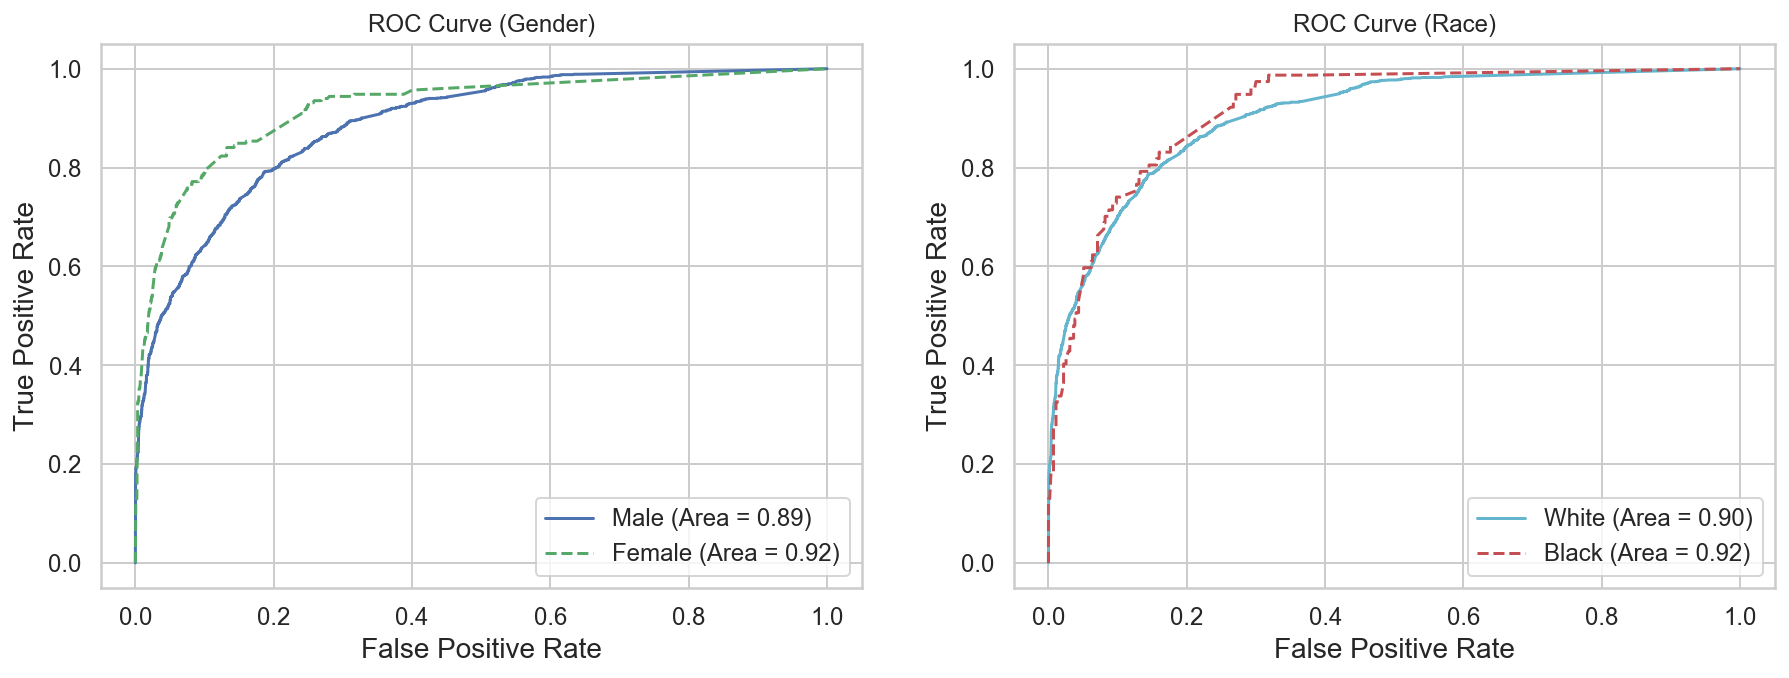

In [85]:
lw = 1.5
f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(fpr_male[1], tpr_male[1], 
        linestyle='-', color='b',
        lw=lw, 
        label='Male (Area = %0.2f)' % roc_auc_male[1])
ax[0].plot(fpr_female[1], tpr_female[1], 
        linestyle='--', color='g',
        lw=lw, 
        label='Female (Area = %0.2f)' % roc_auc_female[1])
ax[1].plot(fpr_white[1], tpr_white[1], 
        linestyle='-', color='c',
        lw=lw, 
        label='White (Area = %0.2f)' % roc_auc_white[1])
ax[1].plot(fpr_black[1], tpr_black[1], 
        linestyle='--', color='r',
        lw=lw, 
        label='Black (Area = %0.2f)' % roc_auc_black[1])
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')
ax[0].set_title('ROC Curve (Gender)')
ax[1].set_title('ROC Curve (Race)')
f.savefig('images/chapter_08_roc_curve_gender_race.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_08_roc_curve_gender_race.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Predictive Quality Parity

In [26]:
from sklearn.metrics import accuracy_score, f1_score

In [27]:
acc_male = accuracy_score(y_male_test, y_pred_male_test)
acc_female = accuracy_score(y_female_test, y_pred_female_test)
acc_white = accuracy_score(y_white_test, y_pred_white_test)
acc_black = accuracy_score(y_black_test, y_pred_black_test)

In [28]:
f1_male = f1_score(y_male_test, y_pred_male_test)
f1_female = f1_score(y_female_test, y_pred_female_test)
f1_white = f1_score(y_white_test, y_pred_white_test)
f1_black = f1_score(y_black_test, y_pred_black_test)

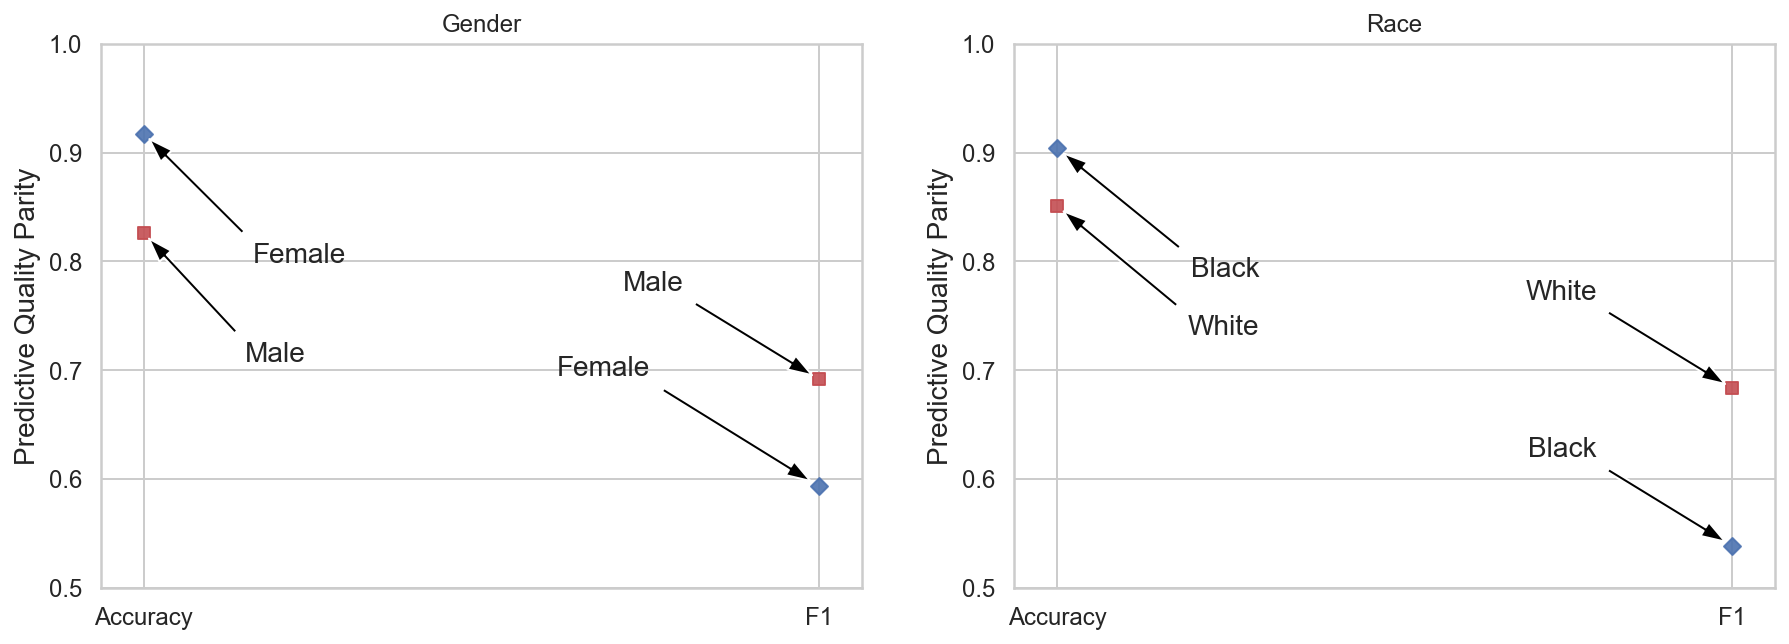

In [137]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
male_sc = plot_scatter([acc_male, f1_male],
                       'Male',
                       ax=ax[0],
                       xticklabels=['Accuracy', 'F1'],
                       marker='s',
                       color='r',
                       xoffsets=[0.24, -0.2],
                       yoffsets=[-0.1, 0.1])
female_sc = plot_scatter([acc_female, f1_female],
                         'Female',
                         ax=ax[0],
                         xticklabels=['Accuracy', 'F1'],
                         marker='D',
                         color='b',
                         xoffsets=[0.3, -0.25],
                         yoffsets=[-0.1, 0.12])
ax[0].set_ylabel('Predictive Quality Parity');
ax[0].set_ylim([0.5, 1.0])
male_sc = plot_scatter([acc_white, f1_white],
                       'White',
                       ax=ax[1],
                       xticklabels=['Accuracy', 'F1'],
                       marker='s',
                       color='r',
                       xoffsets=[0.3, -0.2],
                       yoffsets=[-0.1, 0.1])
female_sc = plot_scatter([acc_black, f1_black],
                         'Black',
                         ax=ax[1],
                         xticklabels=['Accuracy', 'F1'],
                         marker='D',
                         color='b',
                         xoffsets=[0.3, -0.2],
                         yoffsets=[-0.1, 0.1])
ax[1].set_ylabel('Predictive Quality Parity');
ax[1].set_ylim([0.5, 1.0])
ax[0].set_title('Gender')
ax[1].set_title('Race')
f.savefig('images/chapter_08_pred_qual_par_gender_race.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_08_pred_qual_par_gender_race.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Interpretability and Fairness

Source of SHAP code: https://github.com/slundberg/shap/blob/master/notebooks/overviews/Explaining%20quantitative%20measures%20of%20fairness.ipynb

In [31]:
gender_mask = df_X['gender'].values == 1
race_mask = df_X['race'].values == 1

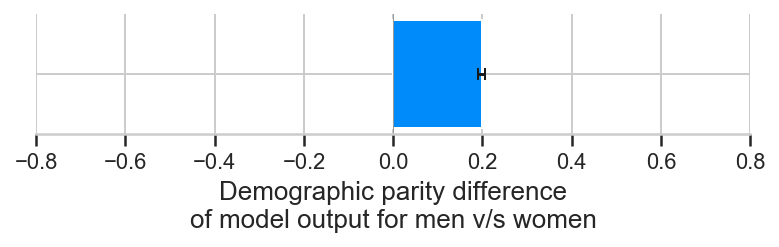

In [38]:
model_outputs = explainer.expected_value[1] + shap_values[1].sum(1)
glabel = "Demographic parity difference\nof model output for men v/s women"
xmin = -0.8
xmax = 0.8
shap.group_difference_plot(shap_values[1].sum(1), 
                           gender_mask, 
                           xmin=xmin, 
                           xmax=xmax, 
                           xlabel=glabel,
                           show=False)
plt.savefig('images/chapter_08_shap_dem_par_diff_model_output_gender.png', dpi=300, bbox_inches='tight');
plt.savefig('images/chapter_08_shap_dem_par_diff_model_output_gender.pdf', 
            format='pdf', dpi=300, bbox_inches='tight');

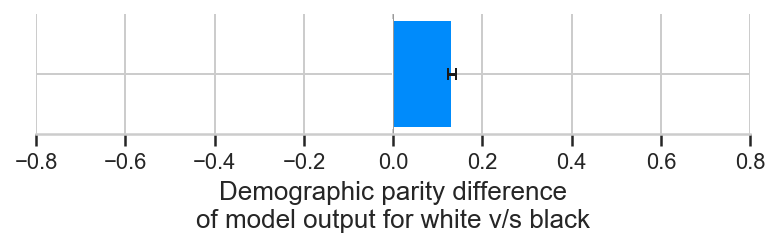

In [39]:
model_outputs = explainer.expected_value[1] + shap_values[1].sum(1)
glabel = "Demographic parity difference\nof model output for white v/s black"
xmin = -0.8
xmax = 0.8
shap.group_difference_plot(shap_values[1].sum(1), 
                           race_mask, 
                           xmin=xmin, 
                           xmax=xmax, 
                           xlabel=glabel,
                           show=False)
plt.savefig('images/chapter_08_shap_dem_par_diff_model_output_race.png', dpi=300, bbox_inches='tight');
plt.savefig('images/chapter_08_shap_dem_par_diff_model_output_race.pdf', 
            format='pdf', dpi=300, bbox_inches='tight');

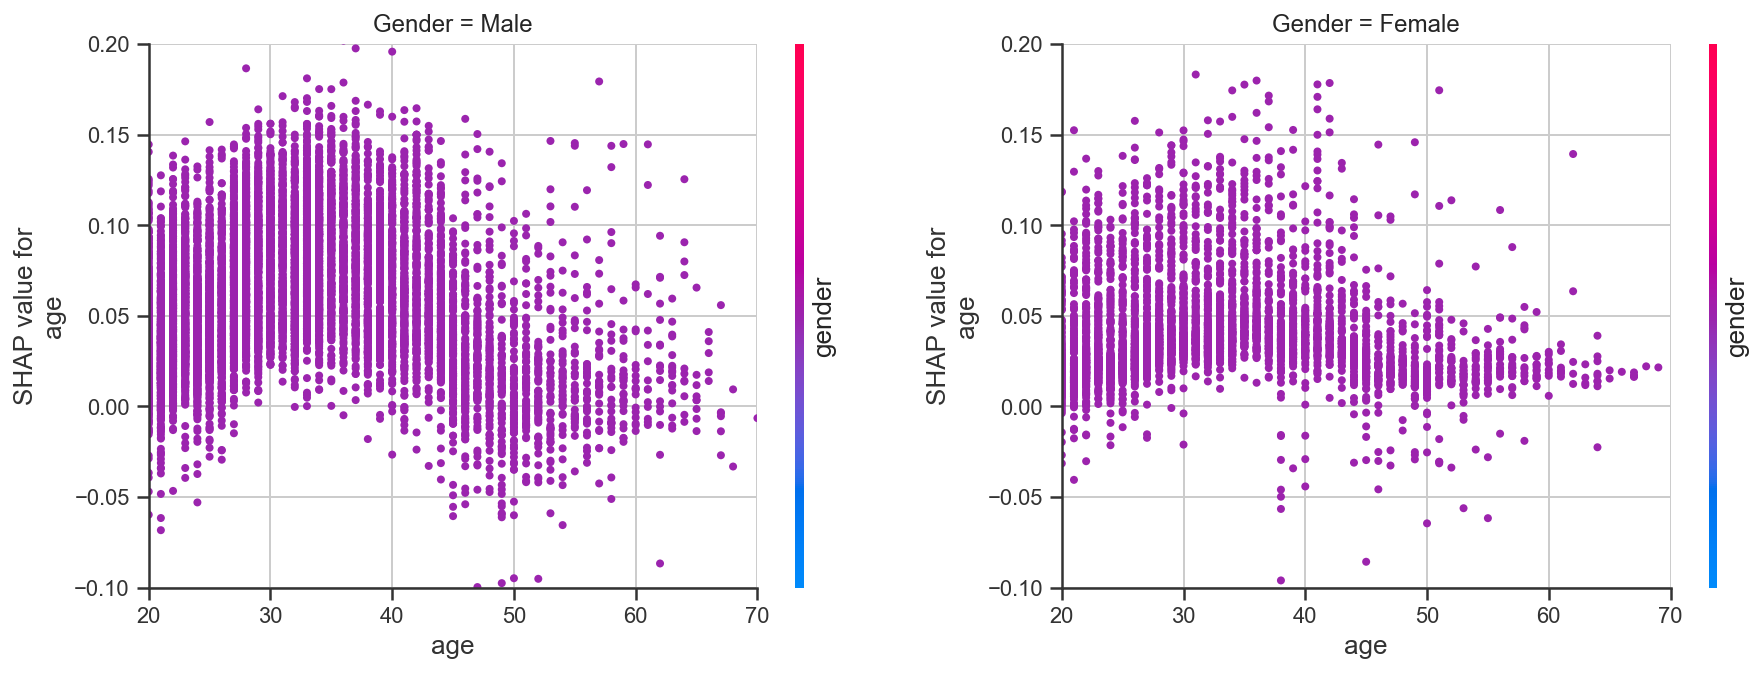

In [52]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
shap.dependence_plot('age', 
                     shap_values[1][male_indices, :], 
                     df_X.iloc[male_indices, :],
                     interaction_index='gender',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[0])
shap.dependence_plot('age', 
                     shap_values[1][female_indices, :], 
                     df_X.iloc[female_indices, :],
                     interaction_index='gender',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[1])
ax[0].set_xlim([20, 70])
ax[1].set_xlim([20, 70]);
ax[0].set_ylim([-0.1, 0.2])
ax[1].set_ylim([-0.1, 0.2]);
ax[0].set_title('Gender = Male')
ax[1].set_title('Gender = Female');
f.savefig('images/chapter_08_dep_plot_age_gender.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_08_dep_plot_age_gender.pdf', format='pdf', dpi=300, bbox_inches='tight');

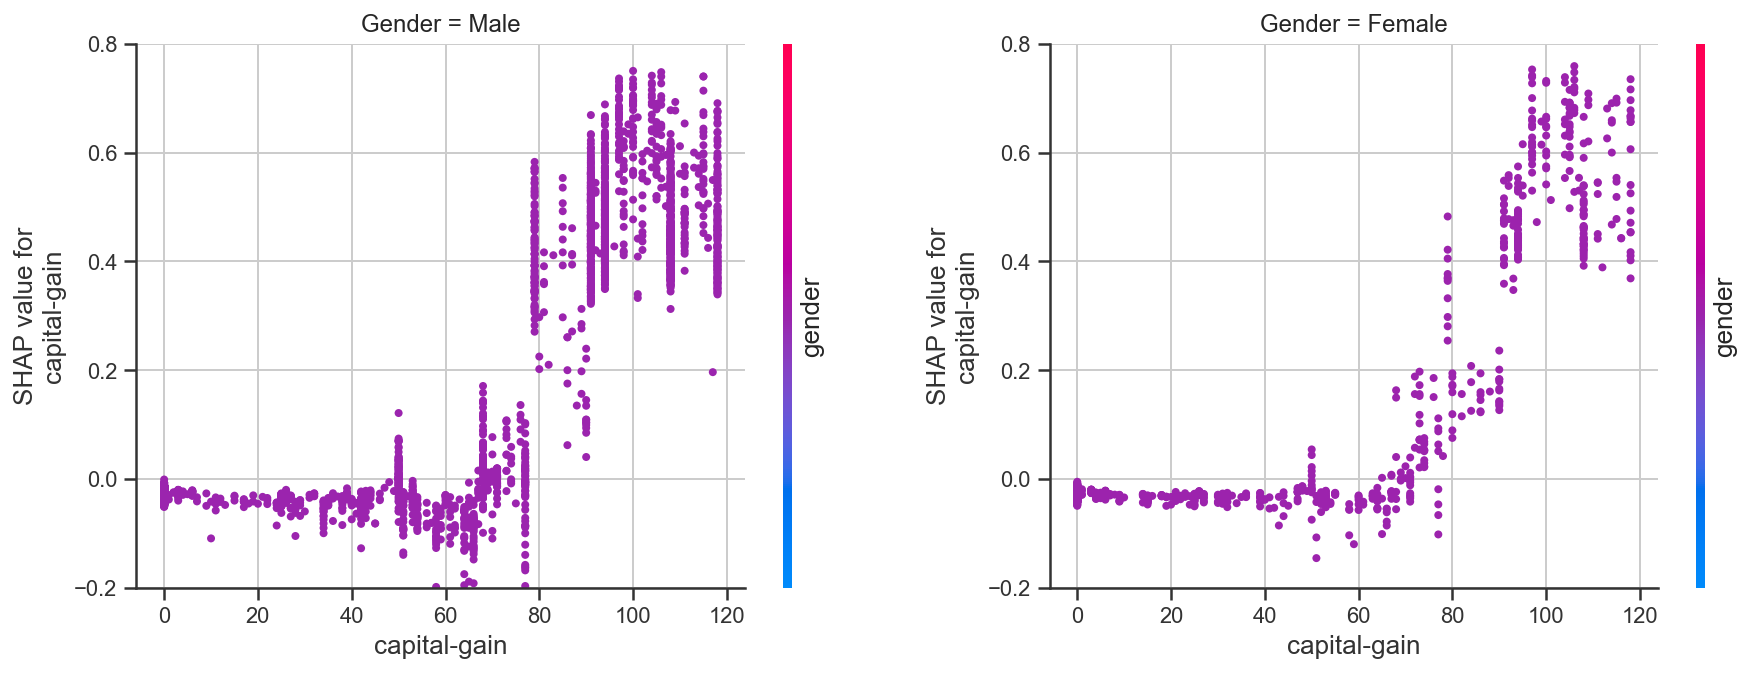

In [53]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
shap.dependence_plot('capital-gain', 
                     shap_values[1][male_indices, :], 
                     df_X.iloc[male_indices, :],
                     interaction_index='gender',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[0])
shap.dependence_plot('capital-gain', 
                     shap_values[1][female_indices, :], 
                     df_X.iloc[female_indices, :],
                     interaction_index='gender',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[1])
ax[0].set_ylim([-0.2, 0.8])
ax[1].set_ylim([-0.2, 0.8]);
ax[0].set_title('Gender = Male')
ax[1].set_title('Gender = Female');
f.savefig('images/chapter_08_dep_plot_capgain_gender.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_08_dep_plot_capgain_gender.pdf', format='pdf', dpi=300, bbox_inches='tight');

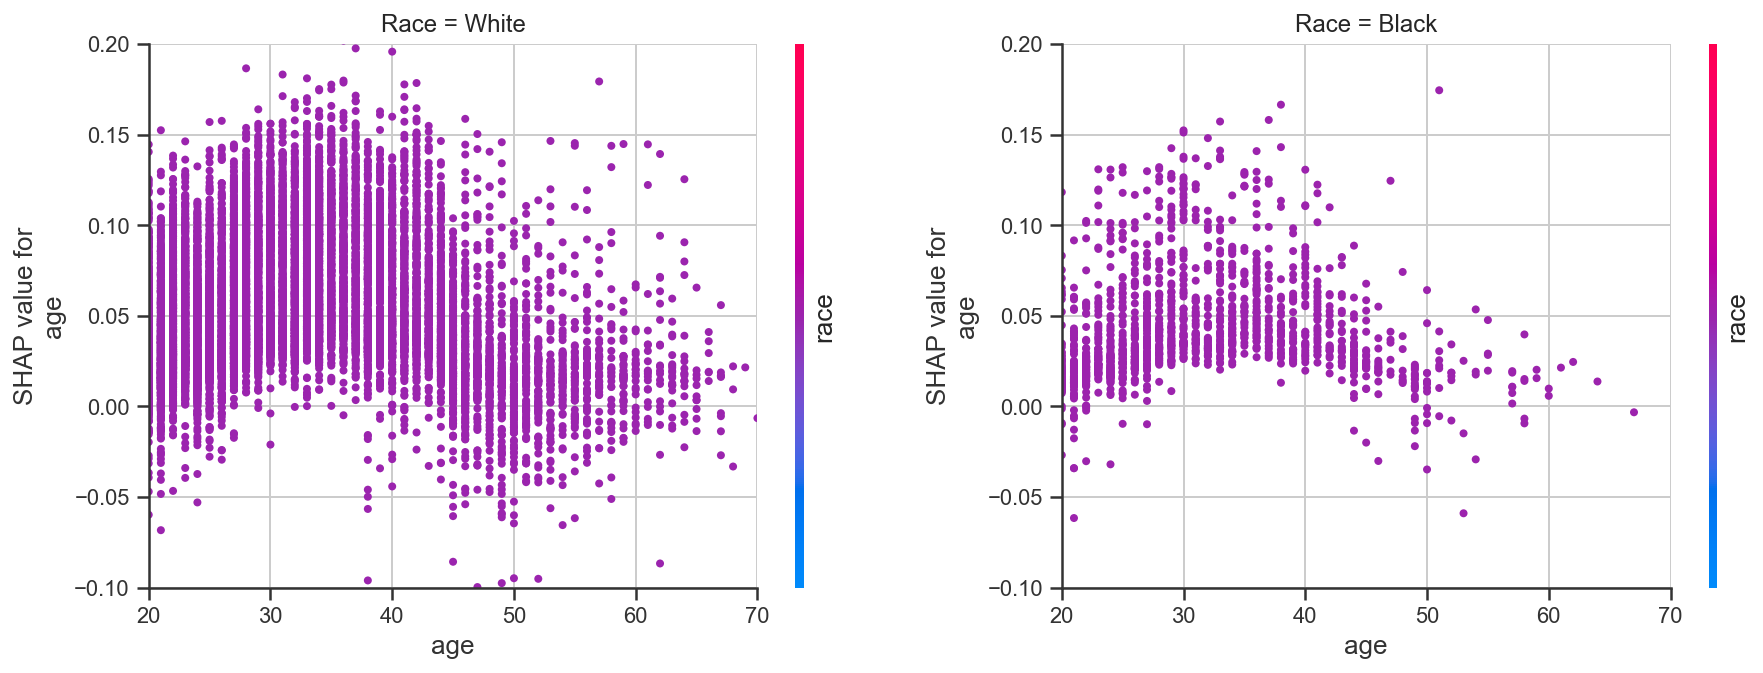

In [54]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
shap.dependence_plot('age', 
                     shap_values[1][white_indices, :], 
                     df_X.iloc[white_indices, :],
                     interaction_index='race',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[0])
shap.dependence_plot('age', 
                     shap_values[1][black_indices, :], 
                     df_X.iloc[black_indices, :],
                     interaction_index='race',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[1])
ax[0].set_xlim([20, 70])
ax[1].set_xlim([20, 70]);
ax[0].set_ylim([-0.1, 0.2])
ax[1].set_ylim([-0.1, 0.2]);
ax[0].set_title('Race = White')
ax[1].set_title('Race = Black');
f.savefig('images/chapter_08_dep_plot_age_race.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_08_dep_plot_age_race.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Mitigating Bias

There are three techniques that we will consider to mitigate bias:
- Fairness through unwaraeness (Pre-processing)
- Label Bias (Pre-processing + In-processing)

## Fairness through Unawareness (Anti-Classification)

Drop the following features:
- Gender
- Race

In [91]:
protected_features = ['gender', 'race']
def drop_columns(X, columns):
    return X.drop(columns=columns)
X_train_ac = drop_columns(X_train, protected_features)
X_test_ac = drop_columns(X_test, protected_features)
df_X_ac = drop_columns(df_X, protected_features)
df_X_display_ac = drop_columns(df_X_display, protected_features)

In [92]:
def create_random_forest_model(n_estimators, 
                               max_depth=10,
                               criterion='gini',
                               random_state=42,
                               n_jobs=4):
    return RandomForestClassifier(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  criterion=criterion,
                                  random_state=random_state,
                                  n_jobs=n_jobs)

In [93]:
adult_model_ac = create_random_forest_model(10, max_depth=20)
adult_model_ac.fit(X_train_ac, y_train)
acc = adult_model_ac.score(X_test_ac, y_test)
print(acc)

0.8564964447317388


In [94]:
y_baseline = [1 for _ in range(len(y_test))]
y_test_pred = adult_model_ac.predict(X_test_ac)
y_test_proba = adult_model_ac.predict_proba(X_test_ac)

In [95]:
from sklearn.metrics import recall_score, precision_score, f1_score

precision = precision_score(y_test, y_test_pred)
p_baseline = precision_score(y_test, y_baseline)
recall = recall_score(y_test, y_test_pred)
r_baseline = recall_score(y_test, y_baseline)
f1 = f1_score(y_test, y_test_pred)
f1_baseline = f1_score(y_test, y_baseline)
print(precision)
print(p_baseline)
print(recall)
print(r_baseline)
print(f1)
print(f1_baseline)

0.7332280978689818
0.23901098901098902
0.6281271129141311
1.0
0.6766205389657683
0.3858093126385809


In [98]:
y_pred_ac = adult_model_ac.predict(df_X_ac)
y_pred_male_ac = y_pred_ac[male_indices]
y_pred_female_ac = y_pred_ac[female_indices]
y_pred_white_ac = y_pred_ac[white_indices]
y_pred_black_ac = y_pred_ac[black_indices]

y_pred_male_test_ac = y_pred_ac[male_indices_test]
y_pred_female_test_ac = y_pred_ac[female_indices_test]
y_pred_white_test_ac = y_pred_ac[white_indices_test]
y_pred_black_test_ac = y_pred_ac[black_indices_test]

In [99]:
y_pred_proba_ac = adult_model_ac.predict_proba(df_X_ac)
y_pred_proba_male_test_ac = y_pred_proba_ac[male_indices_test, :]
y_pred_proba_female_test_ac = y_pred_proba_ac[female_indices_test, :]
y_pred_proba_white_test_ac = y_pred_proba_ac[white_indices_test, :]
y_pred_proba_black_test_ac = y_pred_proba_ac[black_indices_test, :]

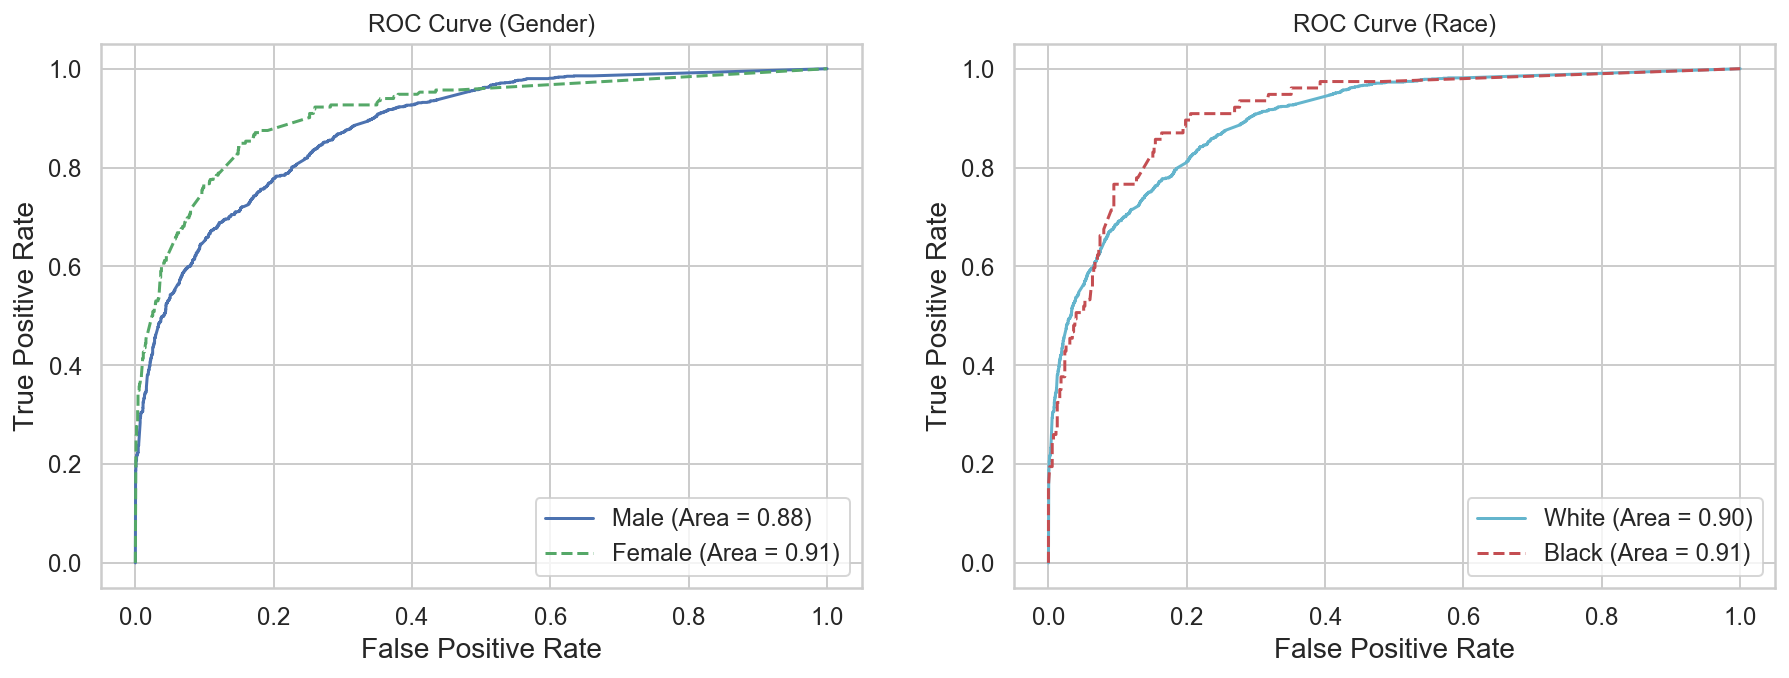

In [101]:
fpr_male, tpr_male, roc_auc_male = compute_roc_auc(y_male_test, 
                                                   y_pred_proba_male_test_ac)
fpr_female, tpr_female, roc_auc_female = compute_roc_auc(y_female_test, 
                                                         y_pred_proba_female_test_ac)
fpr_white, tpr_white, roc_auc_white = compute_roc_auc(y_white_test, 
                                                      y_pred_proba_white_test_ac)
fpr_black, tpr_black, roc_auc_black = compute_roc_auc(y_black_test, 
                                                      y_pred_proba_black_test_ac)

lw = 1.5
f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(fpr_male[1], tpr_male[1], 
        linestyle='-', color='b',
        lw=lw, 
        label='Male (Area = %0.2f)' % roc_auc_male[1])
ax[0].plot(fpr_female[1], tpr_female[1], 
        linestyle='--', color='g',
        lw=lw, 
        label='Female (Area = %0.2f)' % roc_auc_female[1])
ax[1].plot(fpr_white[1], tpr_white[1], 
        linestyle='-', color='c',
        lw=lw, 
        label='White (Area = %0.2f)' % roc_auc_white[1])
ax[1].plot(fpr_black[1], tpr_black[1], 
        linestyle='--', color='r',
        lw=lw, 
        label='Black (Area = %0.2f)' % roc_auc_black[1])
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')
ax[0].set_title('ROC Curve (Gender)')
ax[1].set_title('ROC Curve (Race)')
f.savefig('images/chapter_08_roc_curve_gender_race_ac.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_08_roc_curve_gender_race_ac.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Label Bias

In [111]:
from functools import partial
def prepare_data_for_label_bias(df_X, protected_features,
                                protected_encoded_map):
    df_X_copy = df_X.copy(deep=True)
    def map_feature(row, feature_name, feature_encoded):
        if row[feature_name] == feature_encoded:
            return 1
        return 0
    
    colname_func_map = {}
    for feature_name in protected_features:
        protected_encoded_fv = protected_encoded_map[feature_name]
        for feature_value in protected_encoded_fv:
            colname = f"{feature_name}_{feature_value}"
            colname_func_map[colname] = partial(map_feature, 
                                                feature_name=feature_name,
                                                feature_encoded=protected_encoded_fv[feature_value])
    
    for colname in colname_func_map:
        df_X_copy[colname] = df_X_copy.apply(colname_func_map[colname], 
                                             axis=1)
    df_X_copy = df_X_copy.drop(columns=protected_features)
    return df_X_copy

In [112]:
protected_features = ['gender', 'race']
protected_encoded_map = {
    'gender': {
        'male': 1,
        'female': 0
    },
    'race': {
        'white': 1,
        'black': 0
    }
}
df_X_lb = prepare_data_for_label_bias(df_X, 
                                      protected_features,
                                      protected_encoded_map)

In [116]:
X_train_lb = df_X_lb.iloc[X_train.index]
X_test_lb = df_X_lb.iloc[X_test.index]

In [119]:
PROTECTED_GROUPS = ['gender_male', 'gender_female',
                    'race_white', 'race_black']
protected_train = [np.array(X_train_lb[g]) for g in PROTECTED_GROUPS]
protected_test = [np.array(X_test_lb[g]) for g in PROTECTED_GROUPS]

In [120]:
def get_error_and_violations(y_pred, y, protected_attributes):
    acc = np.mean(y_pred != y)
    violations = []
    for p in protected_attributes:
        protected_idxs = np.where(np.logical_and(p > 0, y > 0))
        positive_idxs = np.where(y > 0)
        violations.append(np.mean(y_pred[positive_idxs]) - np.mean(y_pred[protected_idxs]))
    pairwise_violations = []
    for i in range(len(protected_attributes)):
        for j in range(i+1, len(protected_attributes)):
            protected_idxs = np.where(np.logical_and(protected_attributes[i] > 0, protected_attributes[j] > 0))
            if len(protected_idxs[0]) == 0:
                continue
            pairwise_violations.append(np.mean(y_pred) - np.mean(y_pred[protected_idxs]))
    return acc, violations, pairwise_violations

In [121]:
def debias_weights(original_labels, predicted, protected_attributes, multipliers):
    exponents = np.zeros(len(original_labels))
    for i, m in enumerate(multipliers):
        exponents -= m * protected_attributes[i]
    weights = np.exp(exponents)/ (np.exp(exponents) + np.exp(-exponents))
    #weights = np.where(predicted > 0, weights, 1 - weights)
    weights = np.where(original_labels > 0, 1 - weights, weights)
    return weights

In [128]:
multipliers = np.zeros(len(protected_train))
weights = np.array([1] * X_train.shape[0])
learning_rate = 1.
n_iters = 100

for it in tqdm(range(n_iters)):
    model_lb = create_random_forest_model(10, max_depth=20)
    model_lb.fit(X_train_lb, 
                 y_train, 
                 weights)
    y_pred_train = model_lb.predict(X_train_lb)
    
    weights = debias_weights(y_train, y_pred_train, protected_train, multipliers)
    acc, violations, pairwise_violations = get_error_and_violations(y_pred_train, 
                                                                    y_train, 
                                                                    protected_train)
    multipliers += learning_rate * np.array(violations)
    
    if (it + 1) % n_iters == 0:
        print(multipliers)
        y_pred_test = model_lb.predict(X_test_lb)
        acc, violations, pairwise_violations = get_error_and_violations(y_pred_train, 
                                                                        y_train, 
                                                                        protected_train)
        print("Train Accuracy", acc)
        print("Train Violation", max(np.abs(violations)), " \t\t All violations", violations)
        if len(pairwise_violations) > 0:
            print("Train Intersect Violations", max(np.abs(pairwise_violations)), 
                  " \t All violations", pairwise_violations)
            
        acc, violations, pairwise_violations = get_error_and_violations(y_pred_test, y_test, protected_test)
        print("Test Accuracy", acc)
        print("Test Violation", max(np.abs(violations)), " \t\t All violations", violations)
        if len(pairwise_violations) > 0:
            print("Test Intersect Violations", max(np.abs(pairwise_violations)), 
                  " \t All violations", pairwise_violations)
        print("\n\n")

  0%|          | 0/100 [00:00<?, ?it/s]

[ 0.06489878 -0.3764276   0.16665454 -3.07235711]
Train Accuracy 0.055874272786037495
Train Violation 0.008534604685143776  		 All violations [-0.001471426299092693, 0.008534604685143776, -0.000193565015991215, 0.003568464730290488]
Train Intersect Violations 0.2084050838837131  	 All violations [-0.0867667947516989, 0.06937794530576122, 0.14301802054779006, 0.2084050838837131]
Test Accuracy 0.1468972204266322
Test Violation 0.2482372259248527  		 All violations [-0.0240734625847131, 0.12939486139283296, -0.013633570896015468, 0.2482372259248527]
Test Intersect Violations 0.18540337324169875  	 All violations [-0.08832291891115418, 0.12178109168533247, 0.1386737076964781, 0.18540337324169875]





In [129]:
acc = model_lb.score(X_test_lb, y_test)
print(acc)

0.8531027795733678


In [130]:
y_baseline = [1 for _ in range(len(y_test))]
y_test_pred = model_lb.predict(X_test_lb)
y_test_proba = model_lb.predict_proba(X_test_lb)

In [131]:
from sklearn.metrics import recall_score, precision_score, f1_score

precision = precision_score(y_test, y_test_pred)
p_baseline = precision_score(y_test, y_baseline)
recall = recall_score(y_test, y_test_pred)
r_baseline = recall_score(y_test, y_baseline)
f1 = f1_score(y_test, y_test_pred)
f1_baseline = f1_score(y_test, y_baseline)
print(precision)
print(p_baseline)
print(recall)
print(r_baseline)
print(f1)
print(f1_baseline)

0.6990223463687151
0.23901098901098902
0.6768086544962812
1.0
0.6877361731363792
0.3858093126385809


In [132]:
y_pred_lb = model_lb.predict(df_X_lb)
y_pred_male_lb = y_pred_lb[male_indices]
y_pred_female_lb = y_pred_lb[female_indices]
y_pred_white_lb = y_pred_lb[white_indices]
y_pred_black_lb = y_pred_lb[black_indices]

y_pred_male_test_lb = y_pred_lb[male_indices_test]
y_pred_female_test_lb = y_pred_lb[female_indices_test]
y_pred_white_test_lb = y_pred_lb[white_indices_test]
y_pred_black_test_lb = y_pred_lb[black_indices_test]

In [133]:
y_pred_proba_lb = model_lb.predict_proba(df_X_lb)
y_pred_proba_male_test_lb = y_pred_proba_lb[male_indices_test, :]
y_pred_proba_female_test_lb = y_pred_proba_lb[female_indices_test, :]
y_pred_proba_white_test_lb = y_pred_proba_lb[white_indices_test, :]
y_pred_proba_black_test_lb = y_pred_proba_lb[black_indices_test, :]

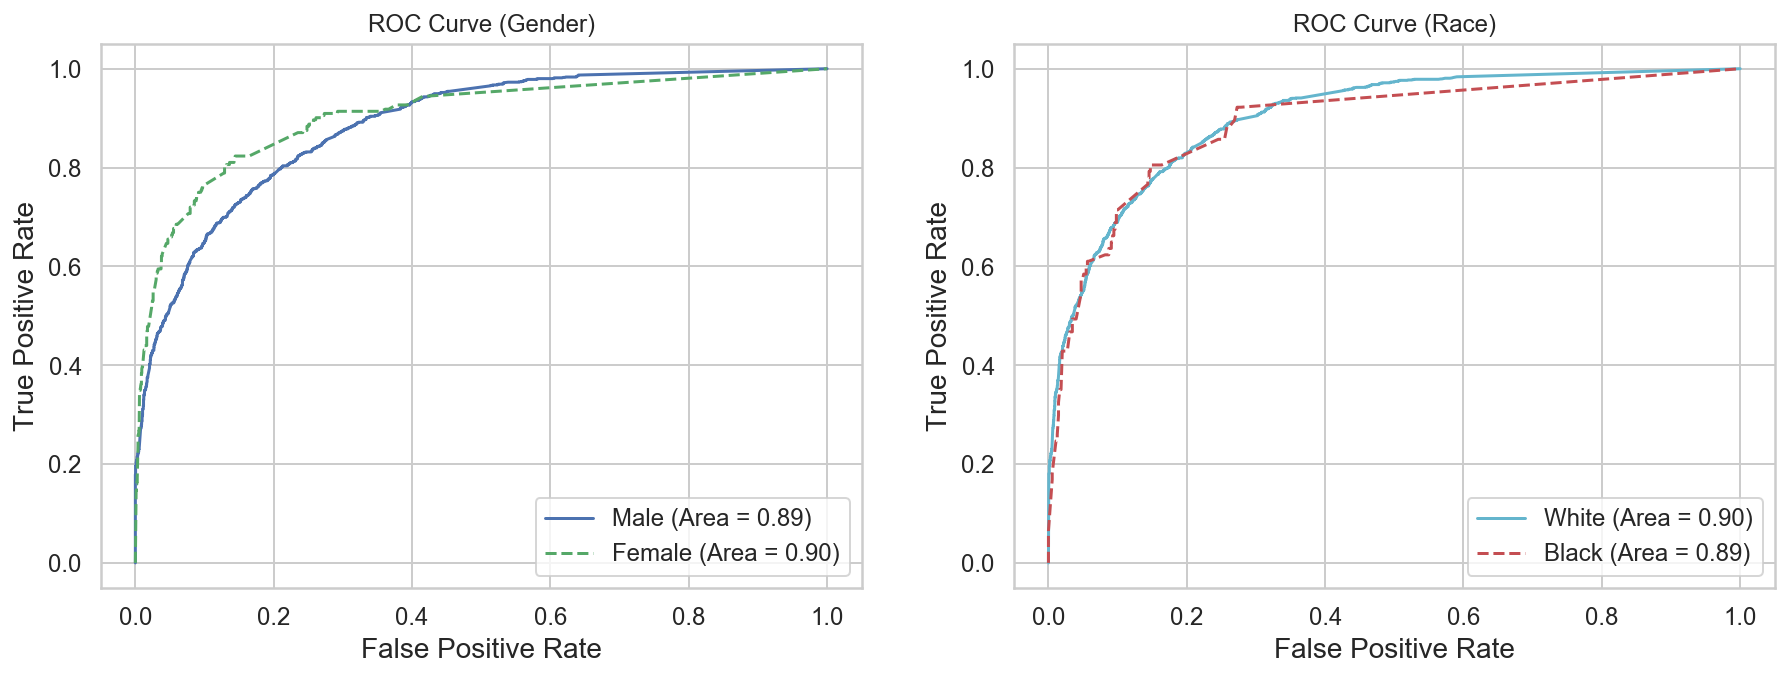

In [135]:
fpr_male, tpr_male, roc_auc_male = compute_roc_auc(y_male_test, 
                                                   y_pred_proba_male_test_lb)
fpr_female, tpr_female, roc_auc_female = compute_roc_auc(y_female_test, 
                                                         y_pred_proba_female_test_lb)
fpr_white, tpr_white, roc_auc_white = compute_roc_auc(y_white_test, 
                                                      y_pred_proba_white_test_lb)
fpr_black, tpr_black, roc_auc_black = compute_roc_auc(y_black_test, 
                                                      y_pred_proba_black_test_lb)

lw = 1.5
f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(fpr_male[1], tpr_male[1], 
        linestyle='-', color='b',
        lw=lw, 
        label='Male (Area = %0.2f)' % roc_auc_male[1])
ax[0].plot(fpr_female[1], tpr_female[1], 
        linestyle='--', color='g',
        lw=lw, 
        label='Female (Area = %0.2f)' % roc_auc_female[1])
ax[1].plot(fpr_white[1], tpr_white[1], 
        linestyle='-', color='c',
        lw=lw, 
        label='White (Area = %0.2f)' % roc_auc_white[1])
ax[1].plot(fpr_black[1], tpr_black[1], 
        linestyle='--', color='r',
        lw=lw, 
        label='Black (Area = %0.2f)' % roc_auc_black[1])
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')
ax[0].set_title('ROC Curve (Gender)')
ax[1].set_title('ROC Curve (Race)')
f.savefig('images/chapter_08_roc_curve_gender_race_lb.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_08_roc_curve_gender_race_lb.pdf', format='pdf', dpi=300, bbox_inches='tight');